<a href="https://colab.research.google.com/github/pinipv/DeepLearning-LearningPropio/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from skimage import io



from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

## Recojo las imagenes de los archivos(aprox. 500 de cada categoria)

In [5]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import cv2


def obtener_imagenes(etiqueta):
      ### Esta variable contendrá las imagenes de base
      imagenes = []
      imagenes_base = []

      y = []
      uploades = files.upload()  #### Este método permite subir archivos a colab(carpeta content)

      for fn in uploades.keys():
          path = '/content/' + fn
          img = image.load_img(path)

          imagenes_base.append(img)

      for i in range(0,len(imagenes_base)):
                
                #### obtenemos cada ruta de la imagen y la leemos guardando asi la imagen
                ima = np.array(imagenes_base[i])
                
                #### Añadimos cara imagen al array de imagenes base    
                image_resized = cv2.resize(ima, (100,100))  
                imagenes.append(image_resized)  #.astype('float32')/255)    ##Las formatearemos mas adelante

                #### Añadimos cada label de la imagen a la lista de labels(y) definitiva
                y.append(str(etiqueta))
                
      #imagenes = np.array(imagenes)
      #print(np.array(imagenes).shape)
      #print(imagenes[0].shape)
      return (imagenes, y)

### De cada set subido retiro 200 imagenes para usar como test, dejando 300 para hacer DataAugmenting 

In [6]:
def sacar_test(nparray, labels):
  test = nparray[:199]     
  train = np.delete(nparray,np.s_[:199],0)
  test_labels = labels[:199]
  train_labels = np.delete(labels, np.s_[:199],0)
  return (train, test, train_labels, test_labels)


## Data Augmenting

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range= 40,   ### Maximo valor de rotacion de la imagen
    width_shift_range = 0.2,
    height_shift_range = 0.2
)

In [8]:
from keras_preprocessing.image.utils import img_to_array
import tensorflow as tf
from tensorflow.keras import layers

def obtener_copias(imagenes_base, etiqueta,copias):
      lista_imagenes = []
      y = []
      generador = train_datagen
      generador.fit(imagenes_base)
      

      for i in imagenes_base:  
              imagen = np.array(i).reshape(-1,100,100,3)  
              it = generador.flow( imagen , batch_size=1)     
              #### Solo se crean las imagenes cuando se hace it.next()
              for j in range(int(copias)):   #### Luego este rango determinará cuantas imágenes se crean
                batch = it.next()
                imag = batch[0]
                imagenn= img_to_array(imag)

                #### Reescalamos la imagen a un formato de (100 x 100)
                IMG_SIZE = 100

                resize_and_rescale = tf.keras.Sequential([
                  layers.Resizing(IMG_SIZE, IMG_SIZE)
                ])

                result = resize_and_rescale(imagenn)

            #### Añadimos la imagen y el label a las listas definitivas
                lista_imagenes.append(result)
                y.append(str(etiqueta))
          
      #### Devolvemos en formato tupla la lista con todas las imagenes y la tupla con todos los labels
      return (lista_imagenes, y)

In [9]:
from sklearn.preprocessing import LabelEncoder

def categorizar_labels(train_labs, test_labs):
  y_encoded = LabelEncoder().fit_transform(train_labs)
  train_categorical = tf.keras.utils.to_categorical(y_encoded)
  y_encoded = LabelEncoder().transform(test_labs)
  test_categorical = tf.keras.utils.to_categorical(y_encoded)

  return (train_categorical, test_categorical)

In [10]:
from sklearn.utils import shuffle

def barajar_train(dataset, labels, seed): 

    #### 'Barajamos' los array de imagenes y de labels

    # ¿¿¿¿¿¿¿Necesario???????
    shuffle_dataset = shuffle(dataset, random_state = int(seed))
    shuffle_labels  = shuffle(labels, random_state = int(seed))
    #
    '''
    a,b,c,d = np.vsplit(shuffle_dataset, 4)
    e,f,g,h = np.vsplit(shuffle_labels, 4)
    '''
    train_dataset = shuffle_dataset#np.concatenate((a,b,c), axis=0)
    #test_dataset  = d
    train_labels  = shuffle_labels#np.concatenate((e,f,g), axis= 0)
    #test_labels   = h

    return (train_dataset, train_labels)

### Esta en principio no seria necesaria

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

def train_test_split(datasets_train, datasets_test, train_labels, test_labels):   #### Dataset y labels serian listas con todos los dataset y todos los labels
  train = datasets_train[0]
  test  = datasets_test[0]
  train_lab = train_labels[0]
  test_lab  = test_labels[0]

  for i in range(1, len(datasets_train)):
    train = np.concatenate((train, datasets_train[i]), axis = 0)
  for i in range(1, len(datasets_test)):
    test  = np.concatenate((test, datasets_test[i]),  axis = 0)
  for i in range(1, len(train_labels)):
    train_lab = np.concatenate((train_lab, train_labels[i]), axis = 0)
  for i in range(1, len(test_labels)):
    test_lab  = np.concatenate((test_lab, test_labels[i]),  axis = 0)


  train_lab_encoded = LabelEncoder().fit_transform(train_lab)
  train_lab_categorical = tf.keras.utils.to_categorical(train_lab_encoded)

  test_lab_encoded = LabelEncoder().fit_transform(test_lab)
  test_lab_categorical = tf.keras.utils.to_categorical(test_lab_encoded)


  shuffle_train = shuffle(train, random_state = 42)
  shuffle_train_lab = shuffle(train_lab_categorical, random_state = 42)
  return (shuffle_train,shuffle_train_lab, test, test_lab_categorical)

# Preprocesado

## Obtencion de imagenes

In [ ]:
airplanes, y_aviones = obtener_imagenes('airplane')
airplanes = np.array(airplanes)

In [ ]:
car, y_car = obtener_imagenes('car')
car = np.array(car)

In [ ]:
cat, y_cat = obtener_imagenes('cat')
cat = np.array(cat)

In [ ]:
dog, y_dog = obtener_imagenes('dog')
dog = np.array(dog)

In [ ]:
flower, y_flower = obtener_imagenes('flower')
flower = np.array(flower)

In [ ]:
fruit, y_fruit = obtener_imagenes('fruit')
fruit = np.array(fruit)

## Separar test de cada una

In [12]:
train_air, test_air, train_labels_air, test_labels_air = sacar_test(airplanes,y_aviones)

In [21]:
train_car, test_car, train_labels_car, test_labels_car = sacar_test(car,y_car)

In [22]:
train_cat, test_cat, train_labels_cat, test_labels_cat = sacar_test(cat,y_cat)

In [23]:
train_dog, test_dog, train_labels_dog, test_labels_dog = sacar_test(dog,y_dog)

In [24]:
train_flower, test_flower, train_labels_flower, test_labels_flower = sacar_test(flower,y_flower)

In [25]:
train_fruit, test_fruit, train_labels_fruit, test_labels_fruit = sacar_test(fruit,y_fruit)

## Obtenemos las copias de cada una con Data Augmenting

In [13]:
generacion_aviones, y_generacion_aviones = obtener_copias(train_air , 'airplane',3)

In [26]:
generacion_cars, y_generacion_cars = obtener_copias(train_car , 'car',3)

In [27]:
generacion_cat, y_generacion_cat = obtener_copias(train_cat , 'cat',3)

In [28]:
generacion_dog, y_generacion_dog = obtener_copias(train_dog , 'dog',3)

In [29]:
generacion_flower, y_generacion_flower = obtener_copias(train_flower , 'flower',3)

In [30]:
generacion_fruit, y_generacion_fruit = obtener_copias(train_fruit , 'fruit',3)

## Unimos los datos finales para train

In [14]:
train_airplanef = np.concatenate((train_air, np.array(generacion_aviones)), axis=0)
labels_airplanes = np.concatenate((train_labels_air, y_generacion_aviones), axis = 0)

train_lbairplane = labels_airplanes.reshape(-1,1)

In [31]:
train_carf = np.concatenate((train_car, np.array(generacion_cars)), axis=0)
labels_cars = np.concatenate((train_labels_car, y_generacion_cars), axis = 0)

train_lbcar = labels_cars.reshape(-1,1)

In [32]:
train_catf = np.concatenate((train_cat, np.array(generacion_cat)), axis=0)
labels_cats = np.concatenate((train_labels_cat, y_generacion_cat), axis = 0)

train_lbcat = labels_cats.reshape(-1,1)

In [33]:
train_dogf = np.concatenate((train_dog, np.array(generacion_dog)), axis=0)
labels_dogs = np.concatenate((train_labels_dog, y_generacion_dog), axis = 0)

train_lbdog = labels_dogs.reshape(-1,1)

In [34]:
train_flowerf = np.concatenate((train_flower, np.array(generacion_flower)), axis=0)
labels_flowers = np.concatenate((train_labels_flower, y_generacion_flower), axis = 0)

train_lbflower = labels_flowers.reshape(-1,1)

In [35]:
train_fruitf = np.concatenate((train_fruit, np.array(generacion_fruit)), axis=0)
labels_fruits = np.concatenate((train_labels_fruit, y_generacion_fruit), axis = 0)

train_lbfruit = labels_fruits.reshape(-1,1)

### train , test, train_labels, test_labels

## Concatenamos todos los train  los test y sus labels y los shuffleamos

In [36]:
train =  np.concatenate((train_airplanef, train_carf, train_catf, train_dogf, train_flowerf, train_fruitf), axis=0)
train_labels = np.concatenate((train_lbairplane, train_lbcar, train_lbcat, train_lbdog, train_lbflower, train_lbfruit))

X_train, y_train = barajar_train(train, train_labels, 42)

In [38]:
test = np.concatenate((test_air, test_car, test_car, test_dog, test_flower, test_fruit))
test_labels = np.concatenate((test_labels_air, test_labels_car, test_labels_cat, test_labels_dog, test_labels_flower, test_labels_fruit), axis =0)

X_test, y_test = barajar_train(test, test_labels, 42)

## En este punto tenemos las imagenes para train, para test(todo ya separado), y sus respectivos labels(sin categorizar)

In [40]:
from sklearn.preprocessing import LabelEncoder

def categorizar_labels(train_labs, test_labs):
  y_encoded = LabelEncoder().fit_transform(train_labs)
  train_categorical = tf.keras.utils.to_categorical(y_encoded)
  y_encoded = LabelEncoder().fit_transform(test_labs)
  test_categorical = tf.keras.utils.to_categorical(y_encoded)

  return (train_categorical, test_categorical)

In [41]:
y_train, y_test = categorizar_labels(y_train, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7224, 100, 100, 3)
(7224, 6)
(1194, 100, 100, 3)
(1194, 6)


## En este punto ya tendriamos todo listo para entrenar el modelo

# Modelo

In [49]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (100,100,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(6, activation = "softmax"))

In [50]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

eS = EarlyStopping(monitor = 'loss',
                   mode='min',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)

In [52]:
history = model.fit(X_train,y_train, validation_split = 0.2, verbose=1, epochs = 20, callbacks=[eS])

Epoch 1/20
181/181 [==============================] - 459s 3s/step - loss: 3.4628 - accuracy: 0.2641 - val_loss: 1.4571 - val_accuracy: 0.3889
Epoch 2/20
181/181 [==============================] - 458s 3s/step - loss: 1.3012 - accuracy: 0.4956 - val_loss: 1.2475 - val_accuracy: 0.5149
Epoch 3/20
181/181 [==============================] - 458s 3s/step - loss: 1.0446 - accuracy: 0.5951 - val_loss: 1.0112 - val_accuracy: 0.5986
Epoch 4/20
181/181 [==============================] - 460s 3s/step - loss: 0.8971 - accuracy: 0.6498 - val_loss: 0.9621 - val_accuracy: 0.6173
Epoch 5/20
181/181 [==============================] - 458s 3s/step - loss: 0.7885 - accuracy: 0.6961 - val_loss: 1.0388 - val_accuracy: 0.6007
Epoch 6/20
181/181 [==============================] - 457s 3s/step - loss: 0.7146 - accuracy: 0.7254 - val_loss: 0.9400 - val_accuracy: 0.6311
Epoch 7/20
181/181 [==============================] - 462s 3s/step - loss: 0.6592 - accuracy: 0.7455 - val_loss: 0.8820 - val_accuracy: 0.6644

In [53]:
history_dict = history.history
acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

<Figure size 432x288 with 0 Axes>

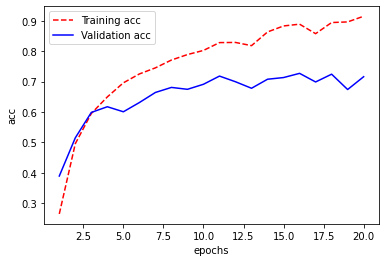

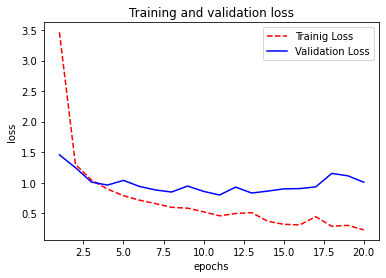

<Figure size 432x288 with 0 Axes>

In [54]:
epochs = range(1, len(acc)+1, 1)

plt.plot  (epochs, acc    , 'r--', label = 'Training acc')
plt.plot  (epochs, val_acc, 'b'  , label = 'Validation acc')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()
plt.plot (epochs, loss    , 'r--', label = 'Trainig Loss')
plt.plot (epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()

In [57]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:',test_acc)

38/38 [==============================] - 20s 515ms/step - loss: 4.2991 - accuracy: 0.5938
Test Accuracy: 0.5938023328781128
